In [1]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
%matplotlib inline 
%precision 5

u'%.5f'

# Solution

In [2]:
## Read in a mesh 
meshfile = open("PlateMeshOrdered.txt",'r').readlines()
n_node = int(meshfile[1])
node_X = np.zeros((n_node,2))
for i in range(n_node):
    aux = meshfile[2+i].split()
    node_X[i,0] = float(aux[0])
    node_X[i,1] = float(aux[1])
n_elem = int(meshfile[3+n_node])
elements = np.zeros((n_elem,3),dtype=int)
for i in range(n_elem):
    aux = meshfile[4+n_node+i].split()
    elements[i,0] = int(aux[0])
    elements[i,1] = int(aux[1])
    elements[i,2] = int(aux[2])
#print(node_X)
#print(elements)

In [3]:
## To build the global stiffness matrix I need to have a function for the 
## gradient of shape functions

def Gradient_N1(x1,y1,x2,y2,x3,y3):
    
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    
    dN1dx = (1./(2*A_e))*(y2-y3)
    dN1dy = (1./(2*A_e))*(x3-x2)
    
    return np.array([dN1dx,dN1dy])

def Gradient_N2(x1,y1,x2,y2,x3,y3):
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    
    dN2dx = (1./(2*A_e))*(y3-y1)
    dN2dy = (1./(2*A_e))*(x1-x3)
    
    return np.array([dN2dx,dN2dy])

def Gradient_N3(x1,y1,x2,y2,x3,y3):
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    
    dN3dx = (1./(2*A_e))*(y1-y2)
    dN3dy = (1./(2*A_e))*(x2-x1)
    return np.array([dN3dx,dN3dy])

def Area(x1,y1,x2,y2,x3,y3):
    edge1 = np.array([x2-x1,y2-y1,0.])
    edge2 = np.array([x3-x1,y3-y1,0.])
    A_e = np.cross(edge1,edge2)
    A_e = np.linalg.norm(A_e)/2.
    return A_e



In [4]:
## Shape functions over the edge
def N1(x,x1e,x2e):
    le = x2e-x1e
    return (1./le)*(x2e-x)

def N2(x,x1e,x2e):
    le = x2e-x1e
    return (1./le)*(x-x1e)

In [5]:
def source(x,y):
    a = 0.25
    b = 1.
    return 4.*a/np.sqrt(x**2 + y**2) - 4. - 2*a*x**2/np.sqrt((x**2 + y**2)**3)- 2*a*y**2/np.sqrt((x**2 + y**2)**3)

In [6]:
## boundary fluxes
def bottomflux(x,y):
    b = 1.
    a = 0.25
    return (2*y-2*a*y/np.sqrt(x**2+y**2) )

def topflux(x,y):
    b = 1.
    a = 0.25
    return -1.*(2*y-2*a*y/np.sqrt(x**2+y**2) )


In [27]:
## Build global stiffness and force vectors
K = np.zeros((n_node,n_node))
F = np.zeros((n_node))
## Loop over elements
for i in range(n_elem):
    # Get the nodes making up this element
    node1 = elements[i,0]-1 # the -1 is because indices start from 0
    node2 = elements[i,1]-1 # the -1 is because indices start from 0
    node3 = elements[i,2]-1 # the -1 is because indices start from 0
    # Get the coordinates of the triangle
    x1 = node_X[node1,0]
    y1 = node_X[node1,1]
    x2 = node_X[node2,0]
    y2 = node_X[node2,1]
    x3 = node_X[node3,0]
    y3 = node_X[node3,1]
    # Call function to evaluate the gradient of shape functions 
    GradN1e = Gradient_N1(x1,y1,x2,y2,x3,y3)
    GradN2e = Gradient_N2(x1,y1,x2,y2,x3,y3)
    GradN3e = Gradient_N3(x1,y1,x2,y2,x3,y3)
    # Build the element stiffness 
    A_e = Area(x1,y1,x2,y2,x3,y3)
    Ke = A_e*np.array([[np.dot(GradN1e,GradN1e),np.dot(GradN1e,GradN2e),np.dot(GradN1e,GradN3e)],
                   [np.dot(GradN2e,GradN1e),np.dot(GradN2e,GradN2e),np.dot(GradN2e,GradN3e)],
                   [np.dot(GradN3e,GradN1e),np.dot(GradN3e,GradN2e),np.dot(GradN3e,GradN3e)]])
    #print(Ke)
    # Assemble into the global stiffness 
    K[node1,node1] += Ke[0,0]
    K[node1,node2] += Ke[0,1]
    K[node1,node3] += Ke[0,2]
    K[node2,node1] += Ke[1,0]
    K[node2,node2] += Ke[1,1]
    K[node2,node3] += Ke[1,2]
    K[node3,node1] += Ke[2,0]
    K[node3,node2] += Ke[2,1]
    K[node3,node3] += Ke[2,2]
    
    # Integrate the source term 
    J = np.array([[x1-x3,y1-y3],[x2-x3,y2-y3]])
    detJ = np.linalg.det(J)
    # Loop over integration points 
    IPxi = np.array([[0.166666666,0.1666666666],[0.6666666666,0.16666666],[0.16666666666,0.666666666]])
    IPw = np.array([0.1666666666,0.166666666,0.1666666666])
    fes = np.zeros((3))
    for i in range(len(IPxi)):
        xIP = IPxi[i,0]*x1 + IPxi[i,1]*x2 + (1-IPxi[i,0]-IPxi[i,1])*x3
        yIP = IPxi[i,0]*y1 + IPxi[i,1]*y2 + (1-IPxi[i,0]-IPxi[i,1])*y3
        # integral(Ni*source), fs = [integral(N1*source),integral(N2*source),integral(N3*source)]
        fes[0] += IPw[i]*IPxi[i,0]*source(xIP,yIP)*detJ
        fes[1] += IPw[i]*IPxi[i,1]*source(xIP,yIP)*detJ
        fes[2] += IPw[i]*(1-IPxi[i,0]-IPxi[i,1])*source(xIP,yIP)*detJ
    
    # Integrate the boundary term for the bottom and top boundaries 
    # use thre point gauss for edge integrals
    gauss_3 = np.array([[-np.sqrt(3./5.),5./9.],[0,8./9.],[np.sqrt(3./5.),5./9.]])
    
    feq = np.zeros((3))
    if y1<-0.99 and y2 <-0.99:
        # first edge is in the bottom NBC
        # means N1 and N2 have to be integrated over edge, we can recast the shape functions over the edge 
        le = x2-x1
        Jedge = le/2.
        for i in range(3):
            x_i = 0.5*(x1+x2) + 0.5*gauss_3[i,0]*le
            # these two are equivalent
            feq[0] += gauss_3[i,1]*((1-gauss_3[i,0])/2.)*bottomflux(x_i,-1.0)*Jedge
            feq[1] += gauss_3[i,1]*((1+gauss_3[i,0])/2.)*bottomflux(x_i,-1.0)*Jedge
            #
            #feq[0] += gauss_3[i,1]*N1(x_i,x1,x2)*bottomflux(x_i,-1.0)*Jedge
            #feq[1] += gauss_3[i,1]*N2(x_i,x1,x2)*bottomflux(x_i,-1.0)*Jedge
    if y2<-0.99 and y3 <-0.99:
        # second edge is in the bottom NBC
        le = x3-x2
        Jedge = le/2.
        for i in range(3):
            x_i = 0.5*(x2+x3) + 0.5*gauss_3[i,0]*le
            feq[1] += gauss_3[i,1]*N1(x_i,x2,x3)*bottomflux(x_i,-1.0)*Jedge
            feq[2] += gauss_3[i,1]*N2(x_i,x2,x3)*bottomflux(x_i,-1.0)*Jedge
    if y3<-0.99 and y1 <-0.99:
        # third edge is in the bottom NBC
        le = x1-x3
        Jedge = le/2.
        for i in range(3):
            x_i = 0.5*(x3+x1) + 0.5*gauss_3[i,0]*le
            feq[2] += gauss_3[i,1]*N1(x_i,x3,x1)*bottomflux(x_i,-1.0)*Jedge
            feq[0] += gauss_3[i,1]*N2(x_i,x3,x1)*bottomflux(x_i,-1.0)*Jedge
    if y1>0.99 and y2 >0.99:
        # first edge is in the top NBC
        le = x1-x2
        Jedge = le/2.
        for i in range(3):
            x_i = 0.5*(x1+x2) + 0.5*gauss_3[i,0]*le
            feq[1] += gauss_3[i,1]*N1(x_i,x2,x1)*topflux(x_i,1.0)*Jedge
            feq[0] += gauss_3[i,1]*N2(x_i,x2,x1)*topflux(x_i,1.0)*Jedge
    if y2>0.99 and y3 >0.99:
        # second edge is in the bottom NBC
        le = x2-x3
        Jedge = le/2.
        for i in range(3):
            x_i = 0.5*(x2+x3) + 0.5*gauss_3[i,0]*le
            feq[2] += gauss_3[i,1]*N1(x_i,x3,x2)*topflux(x_i,1.0)*Jedge
            feq[1] += gauss_3[i,1]*N2(x_i,x3,x2)*topflux(x_i,1.0)*Jedge
    if y3>0.99 and y1 >0.99:
        # third edge is in the top NBC
        le = x3-x1
        Jedge = le/2.
        for i in range(3):
            x_i = 0.5*(x3+x1) + 0.5*gauss_3[i,0]*le
            feq[0] += gauss_3[i,1]*N1(x_i,x1,x3)*topflux(x_i,1.0)*Jedge
            feq[2] += gauss_3[i,1]*N2(x_i,x1,x3)*topflux(x_i,1.0)*Jedge
            
    F[node1]+=fes[0]-feq[0]
    F[node2]+=fes[1]-feq[1]
    F[node3]+=fes[2]-feq[2]

In [28]:
## To solve we need the essential boundary condition
# create zero vector size of nodes and fill inthe first nodes which are on the EBC
d = np.zeros((n_node))
#d_E = np.zeros((56))
a = 0.25
b = 1.
count_EBC = 0
for i in range(n_node):
    if node_X[i,0]<-0.99:
        # this node is in the left boundary 
        d[i] = a**2+b**2+node_X[i,1]**2-2*a*np.sqrt(node_X[i,1]**2+b**2)
        count_EBC += 1
    elif node_X[i,0]>0.99:
        # this node is in the right boundary 
        d[i] = a**2+b**2+node_X[i,1]**2-2*a*np.sqrt(node_X[i,1]**2+b**2)
        count_EBC += 1
    elif abs(node_X[i,0]**2+node_X[i,1]**2-0.25**2)<0.001:
        d[i] = 0
        count_EBC += 1
print(count_EBC)

56


In [29]:
n_E = count_EBC
n_F = n_node-count_EBC
K_E = K[0:n_E,0:n_E]
K_F = K[n_E:,n_E:]
K_EF = K[0:n_E,n_E:]
F_E = F[0:n_E]
F_F = F[n_E:]
d_E = d[0:n_E]
#print(F_F)

In [30]:
#solve
d_F = np.linalg.solve(K_F,F_F- np.dot(K_EF.transpose(),d_E))
#print(d_F)

In [31]:
# reassemble into full d 
for i in range(n_E,n_node):
    d[i] = d_F[i-n_E]

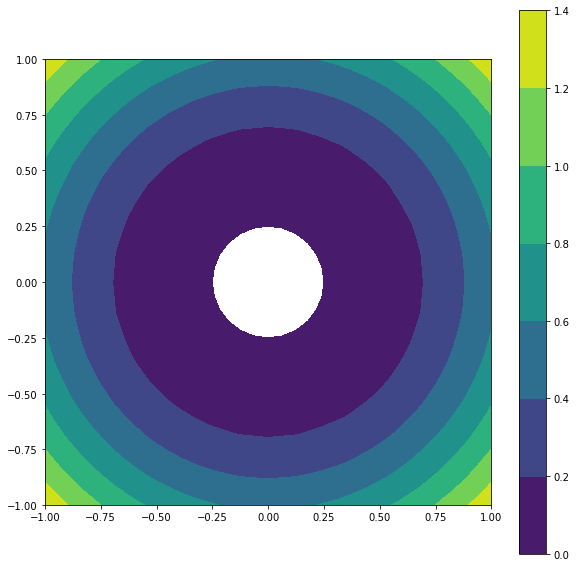

In [32]:
plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')
#levels = [-0.00001, 0.2, 0.4, 0.6, 0.8, 1., 1.2,1.4]
plt.tricontourf(node_X[:,0],node_X[:,1] ,  elements-1, d)
plt.colorbar()

In [60]:
def exact_solution(x,y):
    a = 0.25
    b = 1.
    return x**2+y**2-2*a*np.sqrt(x**2+y**2)+a**2

In [61]:
d_exact = np.zeros((n_node))
for i in range(n_node):
    d_exact[i] = exact_solution(node_X[i,0],node_X[i,1])

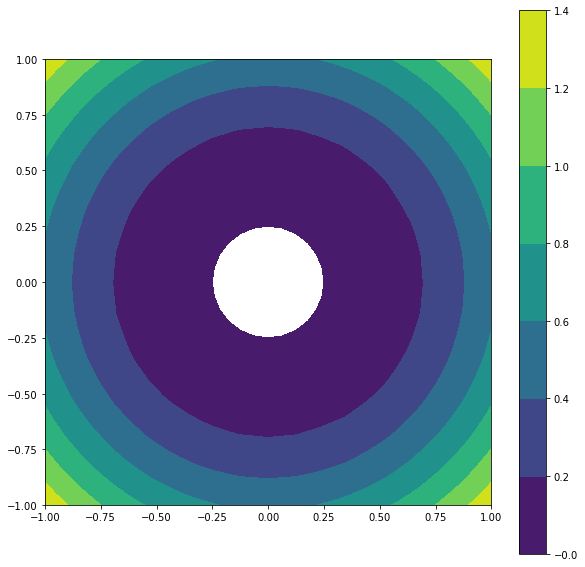

In [108]:
plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal')
levels = [-0.00001, 0.2, 0.4, 0.6, 0.8, 1., 1.2, 1.4]
plt.tricontourf(node_X[:,0],node_X[:,1] ,  elements-1, d_exact, levels)
plt.colorbar()